<a href="https://colab.research.google.com/github/xanasa14/A-Simple-Mapping-Squared-Numbers-Program/blob/master/TransferLearningStrongModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 32540 (delta 2), reused 12 (delta 1), pack-reused 32525
Receiving objects: 100% (32540/32540), 511.71 MiB | 34.75 MiB/s, done.
Resolving deltas: 100% (20821/20821), done.
Checking out files: 100% (2486/2486), done.


In [12]:
from IPython import display 
from tensorflow.keras.preprocessing import image

checkpoint_name = 'mobilenet_v2_1.0_224' #@param
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'
print('Downloading from ', url)
!wget {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded checkpoint from ', url,
      '. It is available as', checkpoint)

Successfully downloaded checkpoint from  https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz . It is available as mobilenet_v2_1.0_224.ckpt


In [14]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg
test_image = image.load_img('/content/sample_data/dog4.jpg', target_size = (128, 128))


--2020-03-06 21:22:08--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.06s   

2020-03-06 21:22:08 (1.88 MB/s) - ‘panda.jpg’ saved [116068/116068]



In [0]:
# setup path
import sys
sys.path.append('/content/models/research/slim')

In [0]:
import tensorflow as tf
from nets.mobilenet import mobilenet_v2

tf.reset_default_graph()

# For simplicity we just decode jpeg inside tensorflow.
# But one can provide any input obviously.
file_input = tf.placeholder(tf.string, ())

image = tf.image.decode_jpeg(tf.read_file(file_input))

images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

# Note: arg_scope is optional for inference.
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average since it produces (1.5-2%) higher 
# accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)

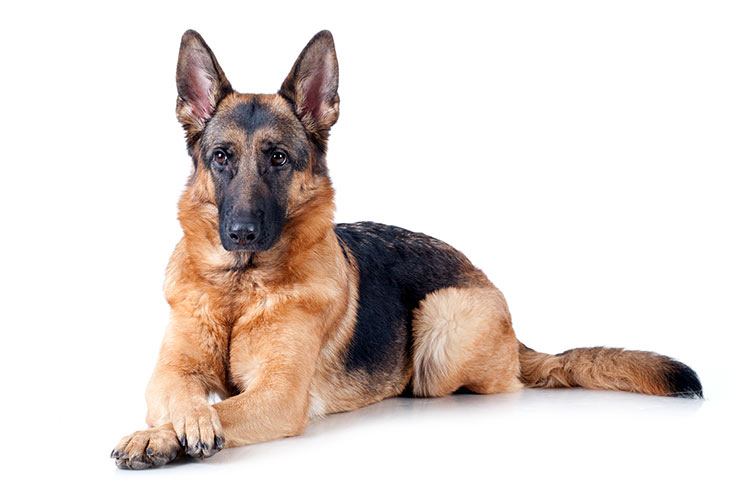

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt
Top 1 prediction:  236 German shepherd, German shepherd dog, German police dog, alsatian 0.5638589


In [20]:
from IPython import display
import pylab
from datasets import imagenet
import PIL
display.display(display.Image('/content/sample_data/dog4.jpg'))

with tf.Session() as sess:
  saver.restore(sess,  checkpoint)
  x = endpoints['Predictions'].eval(feed_dict={file_input: '/content/sample_data/dog4.jpg'})
label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())

In [0]:
import numpy as np
img = np.array(PIL.Image.open('panda.jpg').resize((224, 224))).astype(np.float) / 128 - 1
gd = tf.GraphDef.FromString(open(checkpoint_name + '_frozen.pb', 'rb').read())
inp, predictions = tf.import_graph_def(gd,  return_elements = ['input:0', 'MobilenetV2/Predictions/Reshape_1:0'])

In [10]:
with tf.Session(graph=inp.graph):
  x = predictions.eval(feed_dict={inp: img.reshape(1, 224,224, 3)})

label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 Prediction: ", x.argmax(),label_map[x.argmax()], x.max())

Top 1 Prediction:  389 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 0.89142996
